---
title: "Surrogate Modeling with MID in Python"
---

## Introduction

In modern actuarial science, there is an inherent tension between predictive accuracy and model transparency.
While ensemble tree-based models like **Gradient Boosting Machines (GBMs)** frequently outperform traditional **Generalized Linear Models (GLMs)**, their "black-box" nature presents significant hurdles for model governance, regulatory compliance, and price filing.

This notebook demonstrates a solution using **Maximum Interpretation Decomposition (MID)** via the `{midlearn}` library in Python.

::: {.callout-warning}
## Compatibility Notice
This article relies on features introduced in **midlearn (>= 0.1.3)** and the underlying R package **midr (>= 0.5.3)**. Please ensure your library and package are up to date. Some arguments are not available in earlier versions.
:::

### What is MID?

MID is a functional decomposition framework that acts as a high-fidelity surrogate for complex models.
It deconstructs a black-box prediction function $f(\mathbf{X})$ into several interpretable components: intercept $g_\emptyset$, main effects $g_j(X_j)$, and interaction effects $g_{jk}(X_j, X_k)$.
The prediction is represented as the following additive structure:

$$
f(\mathbf{X}) = g_\emptyset + \sum_{j} g_j(X_{j}) + \sum_{j < k} g_{jk}(X_{j},\;X_{k}) + \dots + g_D(\mathbf{X})
$$

To ensure the uniqueness and interpretability of each component, MID imposes the centering constraints:

$$
\begin{aligned}
\mathbf{E}\left[g_j(X_j)\right] &= 0 \\
\mathbf{E}\left[g_{jk}(X_j, X_k) \mid X_j = x_j\right] &= 0 \quad (\forall x_j) \\
\mathbf{E}\left[g_{jk}(X_j, X_k) \mid X_k = x_k\right] &= 0 \quad (\forall x_k)
\end{aligned}
$$

By replicating a black-box model with this structured approach, we can quantify the "uninterpreted" variance (captured by $g_D(\mathbf{X})$) and derive a representation that captures the superior predictive power of machine learning without sacrificing actuarial clarity.

### Setting Up

We begin by setting up the environment and loading the necessary libraries.

In [1]:
#| label: setup
# utility
from pathlib import Path

# data manipulation
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# predictive modeling
import sklearn.linear_model as lm
import lightgbm as lgb

# import loss function
from sklearn.metrics import mean_poisson_deviance, r2_score

# surrogate modeling
import midlearn as mid

# visualization
from plotnine import *

# load training and testing datasets
PATH = Path("../data")
train = pd.read_parquet(PATH / "train.parquet")
test  = pd.read_parquet(PATH / "test.parquet")

Error importing in API mode: ImportError('On Windows, cffi mode "ANY" is only "ABI".')


Trying to import in ABI mode.


In [2]:
#| label: configulations
#| include: false
# configurations
COLD_RUN = False
LOAD_MID_LGB = True
SAVE_MID_LGB = False

if COLD_RUN:
  np.random.seed(42)
  train = train.sample(5000)
  test  = test.sample(5000)

In Python workflows, we typically partition the dataset into feature matrix $X$, target vector $y$, and weight vector $w$.

In [3]:
#| label: split_Xy
# training set
X_train = train.drop(['Frequency', 'Exposure'], axis=1)
y_train = train['Frequency']
w_train = train['Exposure']
# testing set
X_test  = test.drop(['Frequency', 'Exposure'], axis=1)
y_test  = test['Frequency']
w_test  = test['Exposure']

A key component of our evaluation is the **Weighted Mean Poisson Deviance** defined as follows:

$$
L(\mathbf{y}, \hat{\mathbf{y}}, \mathbf{w}) = \frac{2 \sum_{i=1}^n w_i \left( y_i \log(y_i/\hat{y}_i) - (y_i - \hat{y}_i) \right)}{\sum_{i=1}^n w_i}
$$

## The Interpretable Baseline: GLM

We first fit a GLM to establish a transparent benchmark.
Since GLMs are strictly additive on the link scale, they provide a "ground truth" structure.
This allows us to verify whether the MID framework can accurately recover the original coefficients and linear effects before moving to more complex black-box models.

In [4]:
#| label: fit_glm
# define variable encoder for PoissonRegressor
def one_hot_encode(X):
  cats = X.select_dtypes(include=['object', 'category']).columns.tolist()
  nums = X.select_dtypes(exclude=['object', 'category']).columns.tolist()
  ct = ColumnTransformer(
    transformers=[
      ('cat', OneHotEncoder(drop='first', sparse_output=False), cats),
      ('num', 'passthrough', nums)
    ],
    verbose_feature_names_out=False
  )
  ct.set_output(transform="pandas")
  return ct.fit_transform(X)

# initialize and train a Poisson GLM
fit_glm = lm.PoissonRegressor(alpha=0, max_iter=300)
fit_glm.fit(one_hot_encode(X_train), y_train, sample_weight=w_train)

,alpha,0
,fit_intercept,True
,solver,'lbfgs'
,max_iter,300
,tol,0.0001
,warm_start,False
,verbose,0


In [5]:
#| label: pred_fit_glm
# evaluate fitted model
y_pred_fit_glm = fit_glm.predict(one_hot_encode(X_test))

deviance = mean_poisson_deviance(
  y_true=y_test,
  y_pred=y_pred_fit_glm,
  sample_weight=w_test
)
print("Mean Poisson Deviance:", round(deviance, 6))

Mean Poisson Deviance: 0.470569


### Surrogate Modeling

We apply the `interpret()` function to the GLM.
This step serves as a sanity check: if MID is effective, it should perfectly replicate the predictive behavior of the original GLM.

In [6]:
#| label: mid_glm
# build a surrogate model
mid_glm = mid.MIDExplainer(
  estimator=fit_glm,
  link="log"
)

mid_glm.fit(
  X_train,
  y=fit_glm.predict(one_hot_encode(X_train))
)

,estimator,PoissonRegres... max_iter=300)
,target_classes,None
,params_main,None
,params_inter,None
,penalty,0
,link,'log'
,kernel_type,1
,encoding_frames,{}
,model_terms,None
,singular_ok,False
,mode,1


In [7]:
#| label: pred_mid_glm
# evaluate fitted surrogate
print(
  "Uninterpreted Variation Ratio:",
  round(mid_glm.ratio['working'], 6)
)

y_pred_mid_glm = mid_glm.predict(X_test)

deviance = mean_poisson_deviance(
  y_true=y_test,
  y_pred=y_pred_mid_glm,
  sample_weight=w_test
)
print("Mean Poisson Deviance:", round(deviance, 6))

Uninterpreted Variation Ratio: 0.0


Mean Poisson Deviance: 0.470569


### Model Fidelity

To assess model **fidelity**, i.e., how closely the surrogate replicates the black-box, we calculate the **uninterpreted variation ratio** $\mathbf{U}$.

$$
\mathbf{U}(f,g) = \frac{\sum_{i=1}^n (f(x_i) - g(x_i))^2}{\sum_{i=1}^n (f(x_i) - \bar{f})^2}, \quad \text{where } \bar{f} = \frac{1}{n}\sum_{i=1}^n f(x_i)
$$

This metric represents the proportion of the black-box model's variance that is not captured by the additive components of the MID model.
The **R-squared score**, $\mathbf{R}^2(f,g) = 1 - \mathbf{U}(f,g)$, is a standard measure for this purpose. It is important to note that this $\mathbf{R}^2$ measures the fidelity to the black-box model, not the predictive accuracy relative to the ground truth observations.

In the `{midr}` package, the summary output includes this ratio calculated on the training set.
For models with non-linear links (e.g., Poisson regression), the "working" ratio is computed on the scale of the link function (e.g., $\log$ scale).

To rigorously confirm the model fidelity, it is recommended to evaluate these metrics on a separate testing set.
This ensures that the surrogate model is not just over-fitting the training predictions but has truly captured the underlying functional structure.

In [8]:
#| label: r2_mid_glm
# calculate R-squared on testing dataset
r2_mid = r2_score(
  y_true=np.log(fit_glm.predict(one_hot_encode(X_test))),
  y_pred=np.log(mid_glm.predict(X_test)),
  sample_weight=w_test
)
print("R squared:", round(r2_mid, 10))

R squared: 0.9999999934


As shown by the high $\mathbf{R}^2$ score, the MID surrogate achieves near-perfect fidelity.
This level of agreement justifies using the MID components (main effects and interactions) as a reliable lens through which to interpret the original black-box model’s behavior.

### Feature Effects

While the coefficients of a GLM are directly interpretable, visualizing their functional behavior across the feature space provides a more intuitive grasp of the model’s structure.
In the Python ecosystem, standard libraries for GLMs often lack built-in "term plots" (common in R) to visualize partial effects on the link scale.

Here, the MID surrogate serves as a visualization tool: by appropriately replicating the `PoissonRegressor`, we can directly plot the main effects $g_j(X_j)$ to verify that the linear relationships on the log scale are correctly captured.

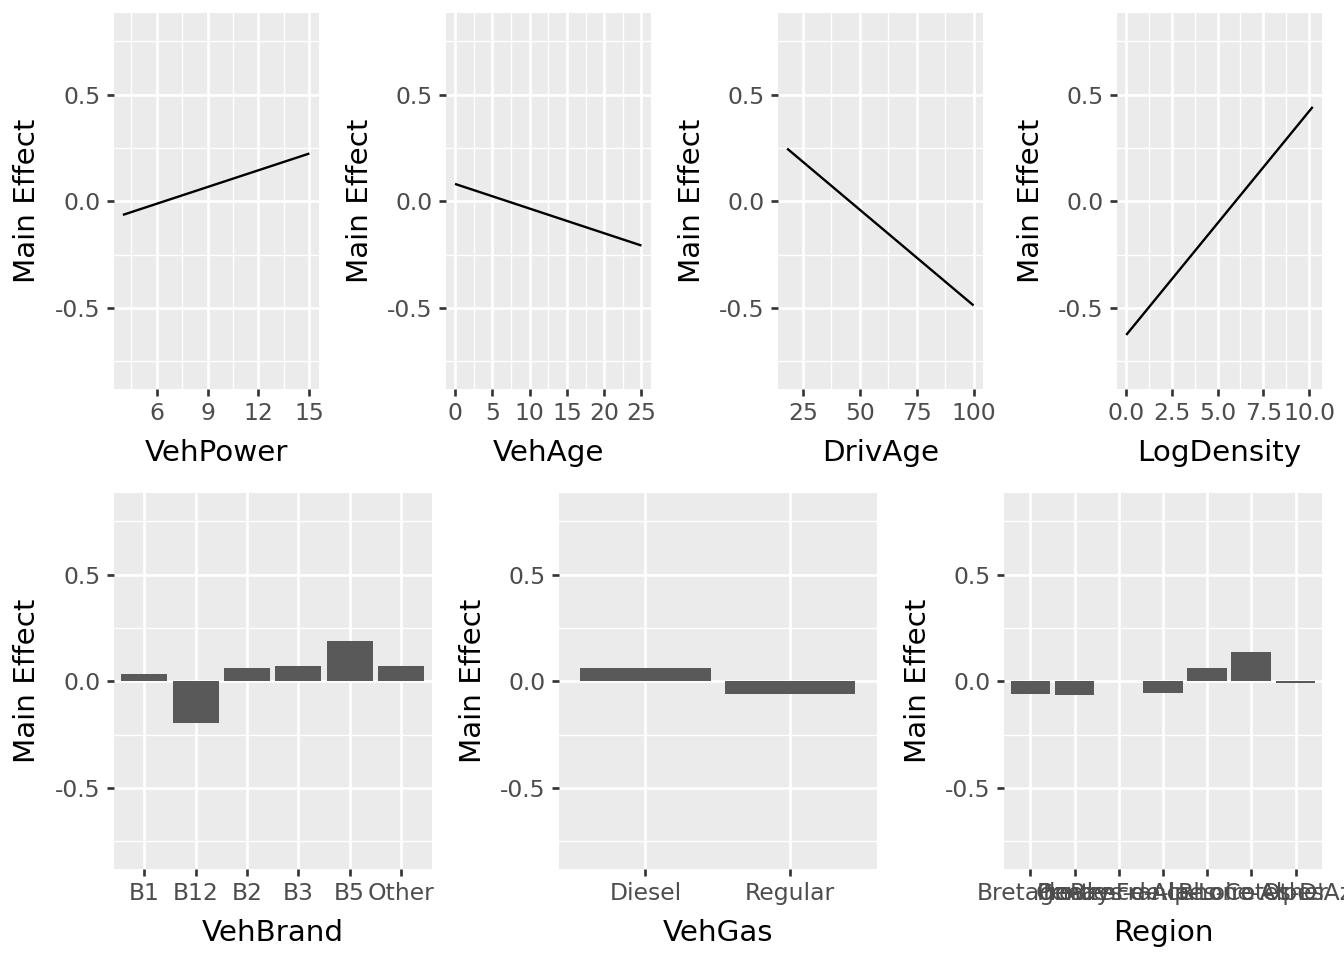

In [9]:
#| label: effects_mid_glm
# main effects of MID surrogate
plots = []
for feature in X_train.columns:
  p = (
  mid_glm.plot(feature) +
    lims(y=[-0.8, 0.8]) +
    labs(y="Main Effect")
  )
  plots.append(p)

display(
  (plots[0] | plots[1] | plots[2] | plots[5]) /
  (plots[3] | plots[4] | plots[6])
)

### Effect Importance

Beyond simple plots for feature effects, `{midr}` provides a suite of diagnostic tools.
First, the **Effect Importance** of a term $j$ is defined as the mean absolute contribution of that term across the population:

$$
\text{Importance}_j = \mathbf{E} \left[ | g_j(X_j) | \right] \approx \frac{1}{n} \sum_{i=1}^n | g_j(x_{ij}) |
$$

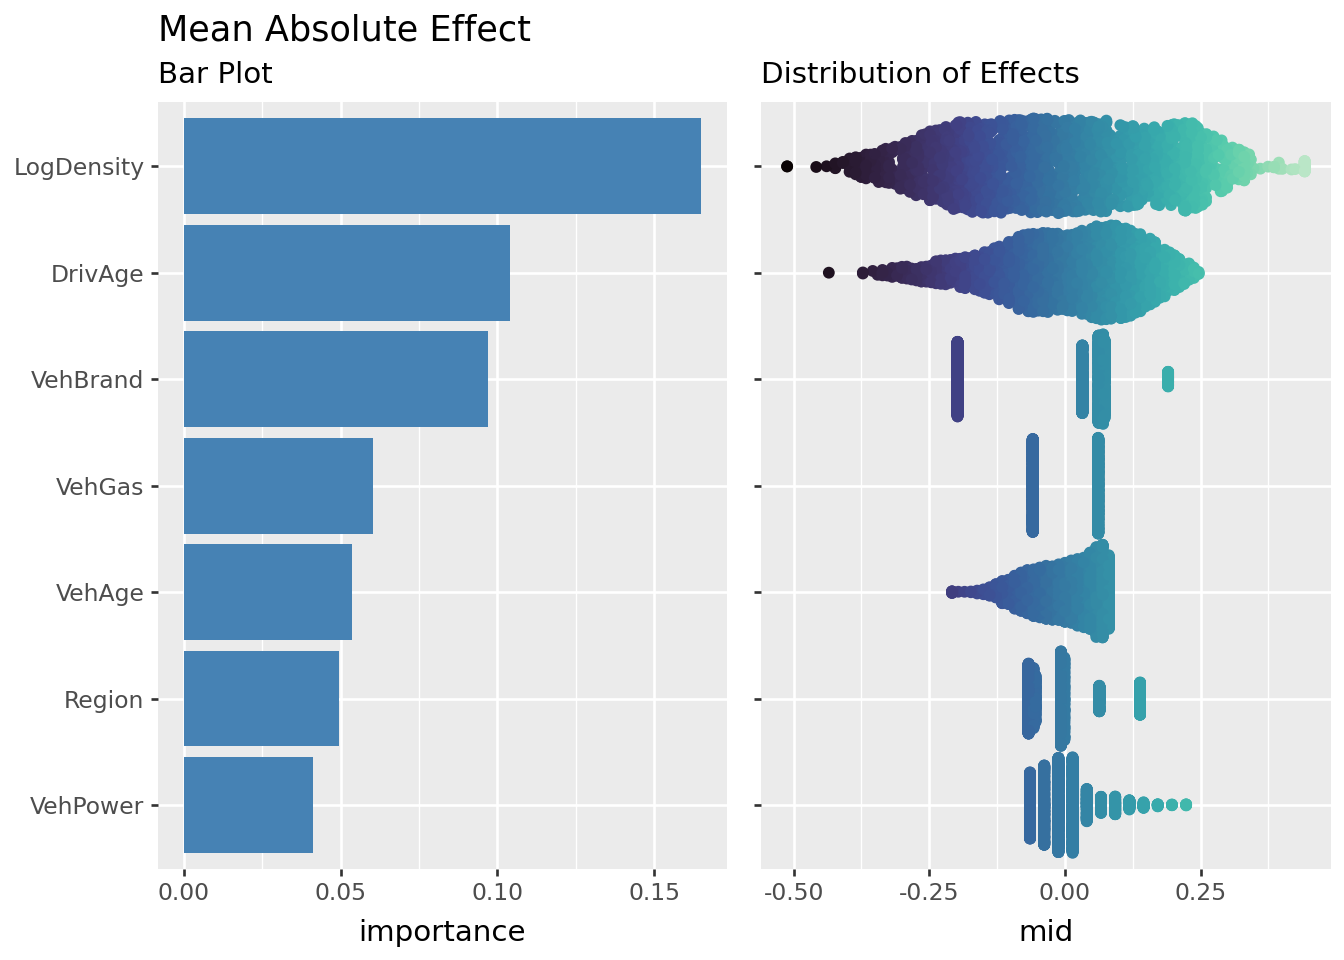

In [10]:
#| label: imp_glm
imp_glm = mid_glm.importance(max_nsamples=2000)

p1 = (
  imp_glm.plot(fill="steelblue") +
  labs(title="Mean Absolute Effect", subtitle="Bar Plot")
)
p2 = (
  imp_glm.plot(style="sinaplot", theme="mako@div") +
  labs(subtitle="Distribution of Effects") +
  theme(legend_position="none", axis_text_y=element_blank())
)
display(p1 | p2)

For interaction terms, the importance is similarly calculated using $g_{jk}(X_j, X_k)$.
This metric allows us to rank features by their average influence on the model's predictions.

### Conditional Expectation

Second, we can explore **Individual Conditional Expectations (ICE)**.
In the MID framework, the ICE for a feature $j$ and a specific observation $i$ is the expected value of the prediction as $X_j$ varies, while keeping other features fixed at their observed values $\mathbf{x}_{\setminus j}^{(i)}$:

$$
\text{ICE}_j^{(i)}(x) = g_\emptyset + g_j(x) + \sum_{k \neq j} g_{jk}(x, x_{ik})
$$

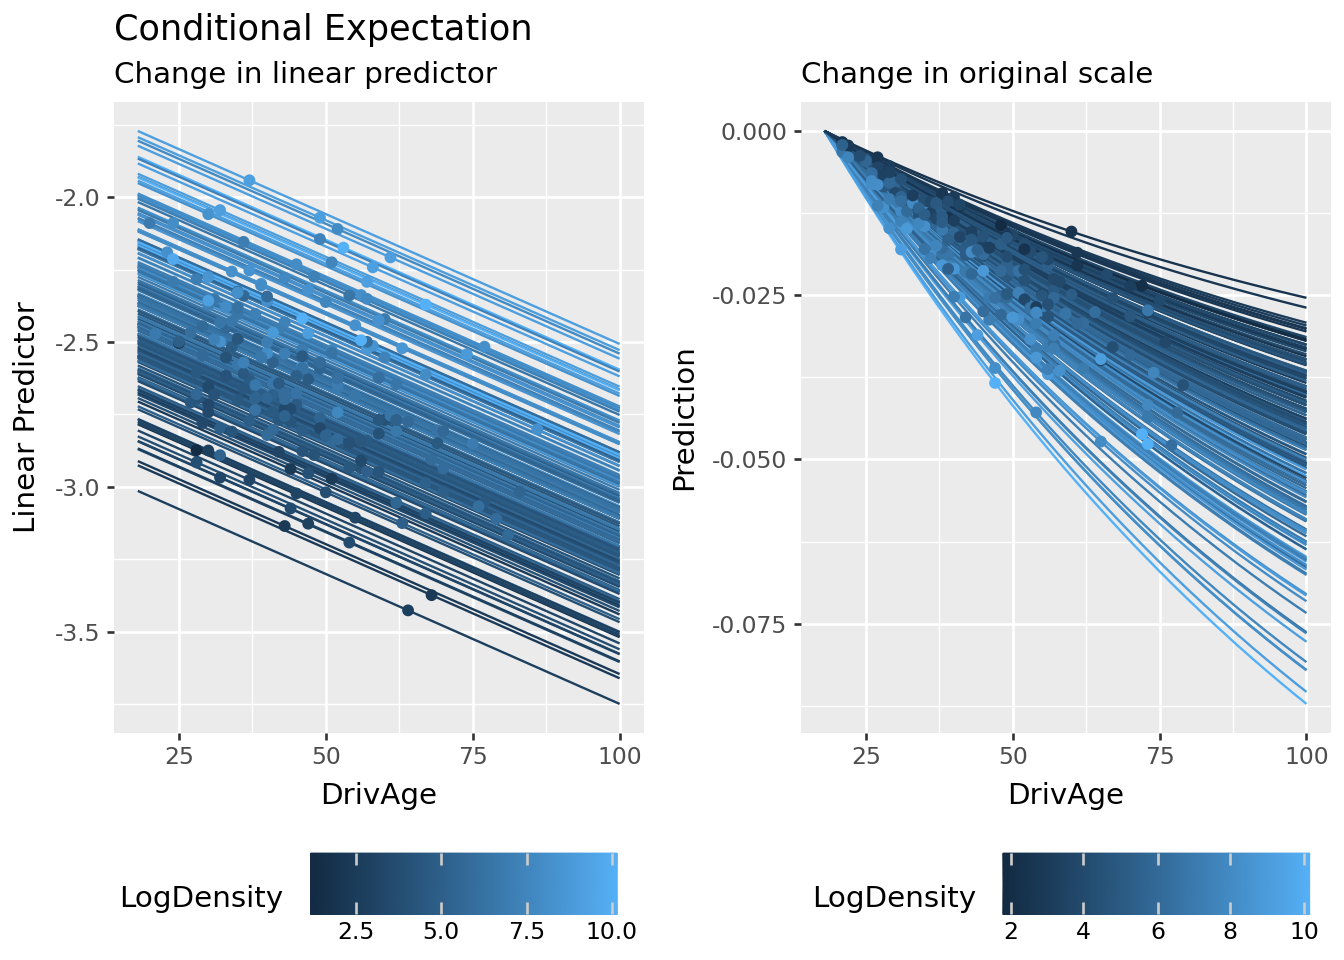

In [11]:
#| label: ice_glm
ice_glm_link = mid_glm.conditional(
  type="link", variable="DrivAge", data=X_train.sample(200)
)
ice_glm = mid_glm.conditional(
  variable="DrivAge", data=X_train.sample(200)
)

p1 = (
  ice_glm_link.plot(theme="bluescale", var_color="LogDensity") +
  theme(legend_position="bottom") +
  labs(y="Linear Predictor",
       title="Conditional Expectation",
       subtitle="Change in linear predictor")
  )
p2 = (
  ice_glm.plot(style="centered", theme="bluescale",
               var_color="LogDensity") +
  theme(legend_position = "bottom") +
  labs(y="Prediction", title="",
       subtitle="Change in original scale")
  )
display(p1 | p2)

Unlike standard black-box models, MID's low-order structure allows us to compute these expectations efficiently and interpret the variation across curves (the "thickness" of the ICE plot) as a direct consequence of specified interaction terms $g_{jk}$.

### Additive Attribution

Third, we perform instance-level explanation through an Additive Breakdown of the prediction.
For any single observation $\mathbf{x}$, the MID surrogate's prediction $g(\mathbf{x})$ is decomposed into the exact sum of its functional components:

$$
g(\mathbf{x}) = \underbrace{g_\emptyset}_{\text{Intercept}} + \underbrace{\sum_{j} g_j(x_j)}_{\text{Main Effects}} + \underbrace{\sum_{j < k} g_{jk}(x_j, x_k)}_{\text{Interactions}}
$$

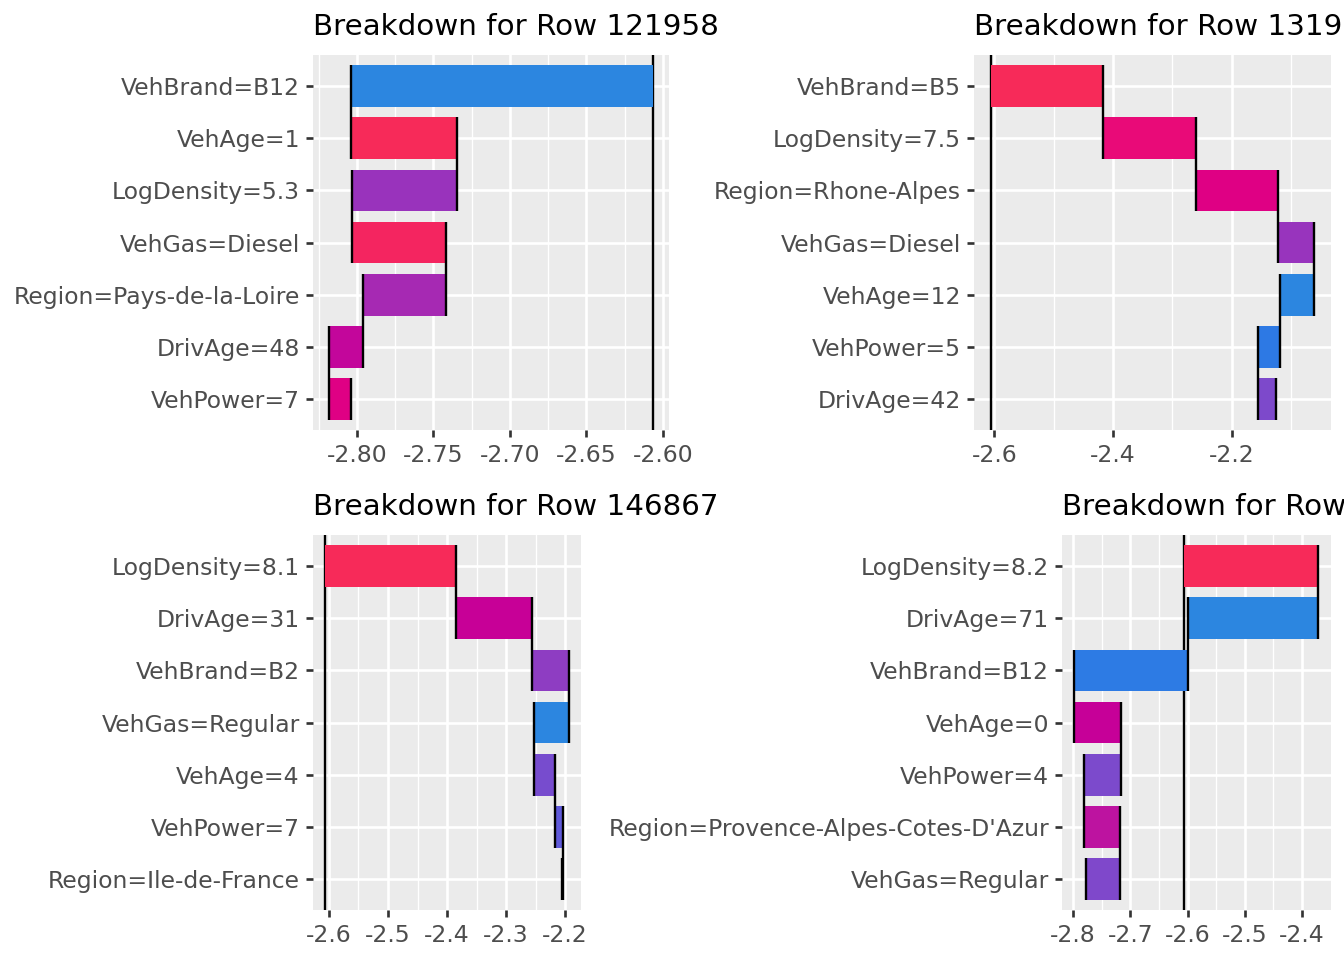

In [12]:
#| label: bd_glm
np.random.seed(42)
row_ids = sorted(np.random.randint(0, train.shape[0], 4).tolist())

bd_plots = []
for idx in row_ids:
  bd = mid_glm.breakdown(row=idx)
  label = "Breakdown for Row " + str(idx)
  p = (
    bd.plot(theme="shap", format_args={'digits': 2}) +
    labs(x="", subtitle=label) +
    theme(legend_position="none")
  )
  bd_plots.append(p)

display(
  (bd_plots[0] | bd_plots[1]) /
  (bd_plots[2] | bd_plots[3]) 
)

By visualizing these contributions in a waterfall plot, we can identify which specific risk factors or interaction effects drove the prediction for a particular instance, such as a high-risk policyholder.

## The Black-Box: LightGBM

While GLMs are transparent, GBMs such as **LightGBM** often yield superior predictive power by capturing high-order interactions.
However, this accuracy comes at the cost of being a black box.

In [13]:
#| label: fit_lgb
# data preprocessing for LightGBM
def str_to_cat(X):
  cats = X.select_dtypes(include=['object', 'category']).columns.tolist()
  X = X.copy()
  X[cats] = X[cats].astype('category')
  return X

# model parameters (mirroring the R version)
params_lgb = {
  'objective': "poisson",
  'n_estimators': 551,
  'learning_rate': 0.01672663973358928,
  'num_leaves': 61,
  'max_depth': 19,
  'min_child_samples': 10,
  'subsample': 0.8123000876841823,
  'colsample_bytree': 0.6507848978461632,
  'reg_alpha': 4.234603347091384,
  'reg_lambda': 8.790496879009705e-07,
  'random_state': 42,
  'n_jobs': -1,
  'verbosity': -1,
  'importance_type': 'gain'
}

# split datasets for validation
valid_n = int(X_train.shape[0] * 0.2)
train_X, valid_X = X_train.iloc[valid_n:], X_train.iloc[:valid_n]
train_y, valid_y = y_train[valid_n:], y_train[:valid_n]
train_w, valid_w = w_train[valid_n:], w_train[:valid_n]

# initialize and train a LightGBM
fit_lgb = lgb.LGBMRegressor(**params_lgb)

fit_lgb.fit(
  X=str_to_cat(train_X),
  y=train_y,
  sample_weight=train_w,
  eval_set=[(valid_X, valid_y)],
  eval_sample_weight=[valid_w],
  callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Training until validation scores don't improve for 50 rounds


Early stopping, best iteration is:
[458]	valid_0's poisson: 0.263843


,boosting_type,'gbdt'
,num_leaves,61
,max_depth,19
,learning_rate,0.01672663973358928
,n_estimators,551
,subsample_for_bin,200000
,objective,'poisson'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,10


In [14]:
#| label: pred_fit_lgb
# evaluate fitted model
y_pred_fit_lgb = fit_lgb.predict(str_to_cat(X_test))

deviance = mean_poisson_deviance(
  y_true=y_test,
  y_pred=y_pred_fit_lgb,
  sample_weight=w_test
)
print("Mean Poisson Deviance:", round(deviance, 6))

Mean Poisson Deviance: 0.465148


### Surrogate Modeling

We use `{midr}` to replicate the LightGBM model.
By including interaction terms in the model formula, we allow the surrogate to capture the joint relationships that the GBM has learned.
The goal is to approximate the LightGBM function $f_{LGB}(\mathbf{x})$ with our interpretable structure $g(\mathbf{x})$:

$$
f_{LGB}(\mathbf{x}) \approx g(\mathbf{x}) = g_\emptyset + \sum_{j} g_j(x_j) + \sum_{j < k} g_{jk}(x_j, x_k)
$$

::: {.callout-warning}
### Computational Considerations
Including all second-order interactions using the `(...)^2` syntax results in $p(p-1)/2$ interaction terms.
For high-dimensional data, this can be memory-intensive.
Users should ensure sufficient RAM is available or consider limiting the formula to the most relevant features, or using a subset of the training set.
:::

In [15]:
#| label: mid_lgb
#| eval: false
# build a surrogate model
mid_lgb = mid.MIDExplainer(
  estimator=fit_lgb,
  interactions=True,
  link="log",
  penalty=0.01
)

mid_lgb.fit(
  X_train, 
  y=fit_lgb.predict(X_train),
  sample_weight=w_train
)

In [16]:
#| label: load_mid_lgb
#| echo: false
import os
import joblib
if LOAD_MID_LGB and os.path.exists("../data/mid_lgb.pkl"):
  mid_lgb = joblib.load("../data/mid_lgb.pkl")
else:
  mid_lgb = mid.MIDExplainer(
    estimator=fit_lgb,
    interactions=True,
    link="log",
    penalty=0.01
  )
  mid_lgb.fit(
    X_train, 
    y=fit_lgb.predict(X_train),
    sample_weight=w_train
  )
  if SAVE_MID_LGB:
    joblib.dump(mid_lgb, "../data/mid_lgb.pkl")
mid_lgb

,estimator,LGBMRegressor... verbosity=-1)
,target_classes,None
,params_main,None
,params_inter,None
,penalty,0.01
,link,'log'
,kernel_type,1
,encoding_frames,{}
,model_terms,None
,singular_ok,False
,mode,1


In [17]:
#| label: pred_mid_lgb
# evaluate fitted surrogate
print(
  "Uninterpreted Variation Ratio:",
  round(mid_lgb.ratio['working'], 6)
)

y_pred_mid_lgb = mid_lgb.predict(X_test)

deviance = mean_poisson_deviance(
  y_true=y_test,
  y_pred=y_pred_mid_lgb,
  sample_weight=w_test
)
print("Mean Poisson Deviance:", round(deviance, 6))

Uninterpreted Variation Ratio: 0.09313


Mean Poisson Deviance: 0.467089


### Model Fidelity

To measure how successfully our surrogate replicates the LightGBM model, we use the R-squared score on the link scale ($\log$ scale). 

In [18]:
#| label: r2_mid_lgb
# calculate R-squared on testing dataset
r2_mid = r2_score(
  y_true=np.log(fit_lgb.predict(str_to_cat(X_test))),
  y_pred=np.log(mid_lgb.predict(X_test)),
  sample_weight=w_test
)
print("R squared:", round(r2_mid, 10))

R squared: 0.9050963659


### Feature Effects

C:\Users\daysb\anaconda3\Lib\site-packages\plotnine\geoms\geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


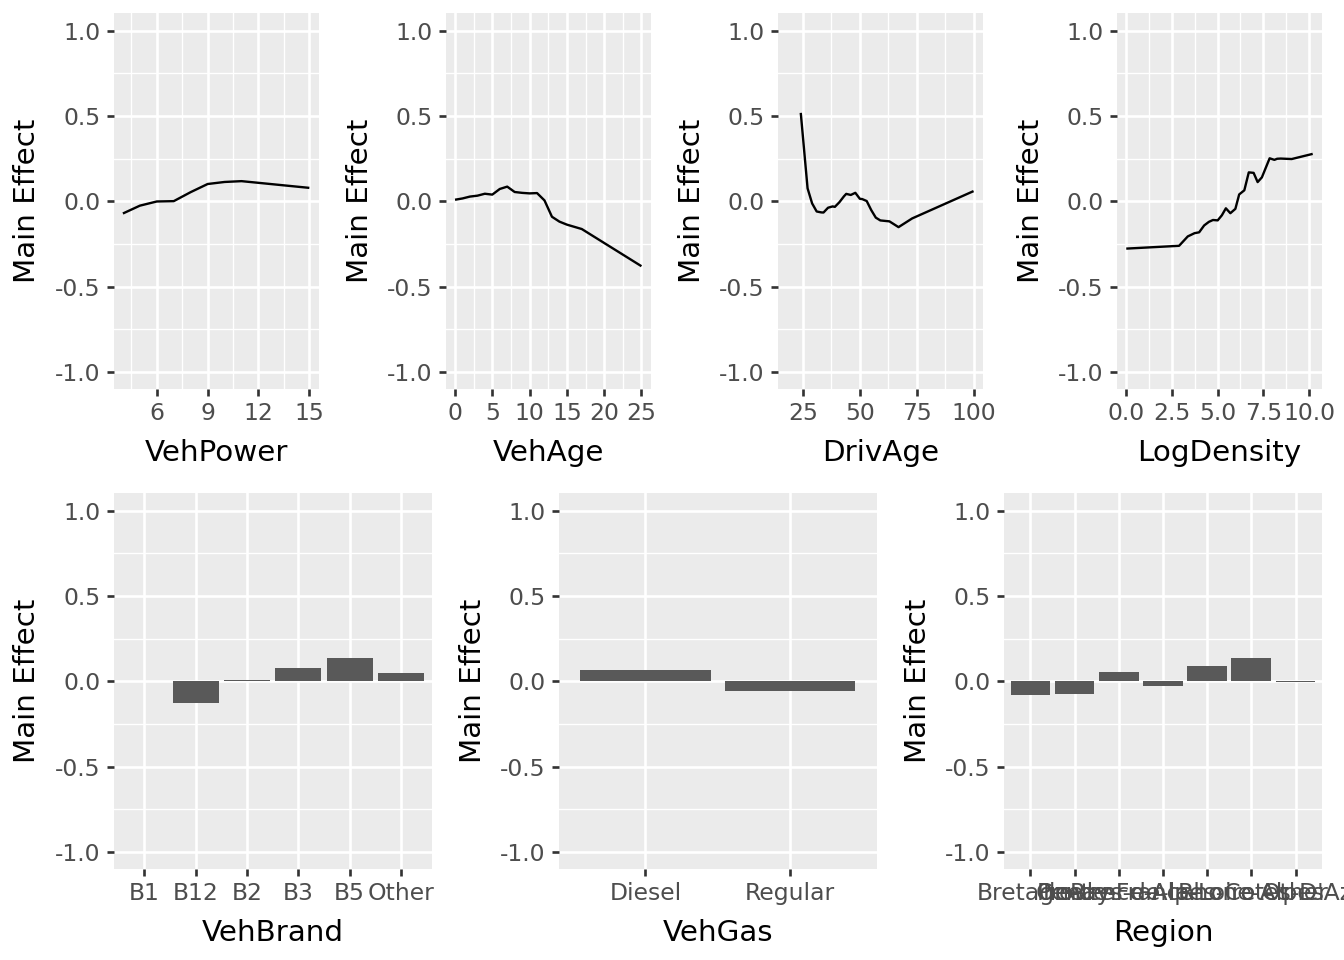

In [19]:
#| label: effects_mid_lgb
#| warning: false
# main effects of MID surrogate
plots = []
for feature in X_train.columns:
  p = (
  mid_lgb.plot(feature) +
    lims(y=[-1.0, 1.0]) +
    labs(y="Main Effect")
  )
  plots.append(p)

display(
  (plots[0] | plots[1] | plots[2] | plots[5]) /
  (plots[3] | plots[4] | plots[6])
)

A key advantage of `{midr}` is its ability to isolate interaction effects $g_{jk}$ from main effects $g_j$.
This is particularly useful to understand the joint impact of two variables (e.g., `Region` and `LogDensity`).

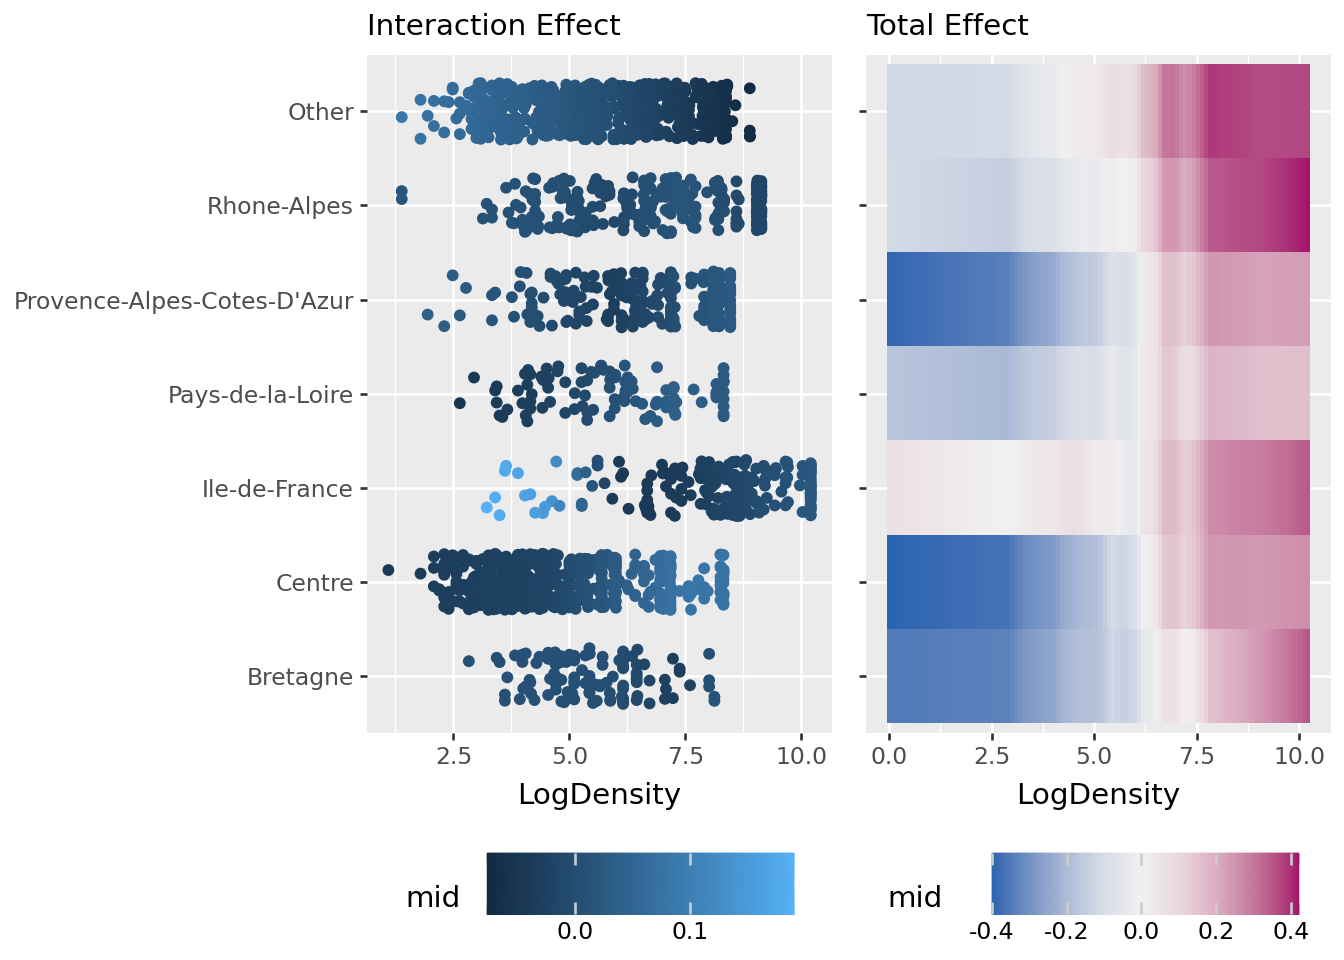

In [20]:
#| label: interaction
p1 = (
  mid_lgb.plot("LogDensity:Region", style="data",
               data=train.sample(2000), theme="bluescale") +
  labs(subtitle="Interaction Effect", y="") +
  theme(legend_position="bottom")
)
p2 = (
  mid_lgb.plot("LogDensity:Region", main_effects=True) +
  labs(subtitle="Total Effect", y="") +
  theme(axis_text_y=element_blank(),
        legend_position="bottom")
)
display(p1 | p2)

### Effect Importance

To rank the influence of each component discovered in the LightGBM model, we calculate the Effect Importance, defined as the average absolute contribution.

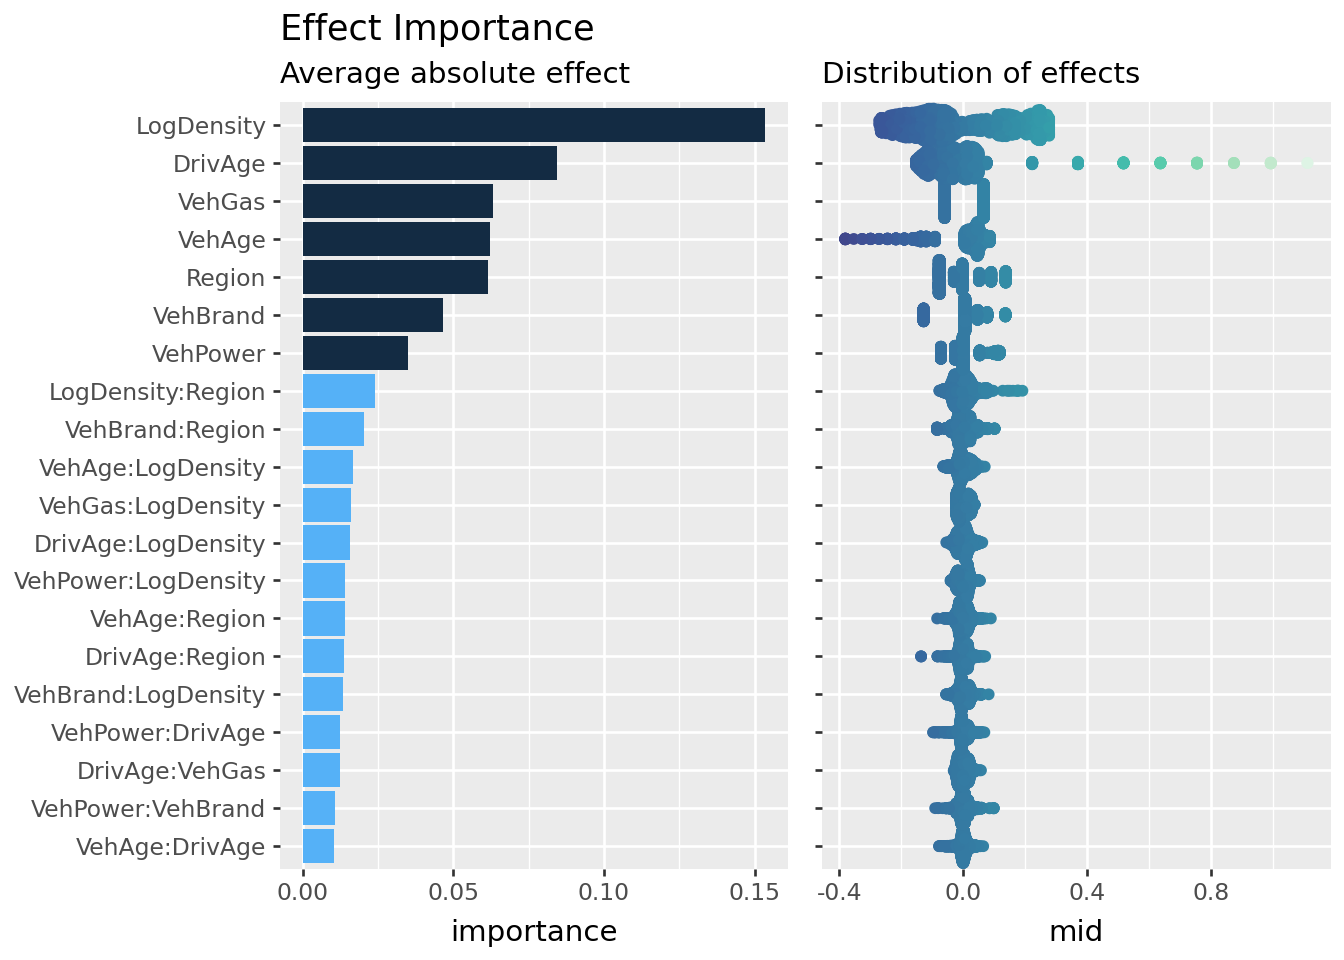

In [21]:
#| label: imp_lgb
imp_lgb = mid_lgb.importance(max_nsamples=2000)

p1 = (
  imp_lgb.plot(theme="bluescale@qual", max_nterms=20) +
  labs(title="Effect Importance", subtitle="Average absolute effect") +
  theme(legend_position="none")
)
p2 = (
  imp_lgb.plot(style="sinaplot", theme="mako@div", max_nterms=20) +
  labs(title="", subtitle="Distribution of effects") +
  theme(axis_text_y=element_blank(), legend_position="none")
)
display(p1 | p2)

### Conditional Expectation

We further explore the model's behavior using the ICE plot.
In the MID framework, the variation in ICE curves for a feature $j$ is explicitly governed by the interaction terms $g_{jk}$ identified from the LightGBM model.

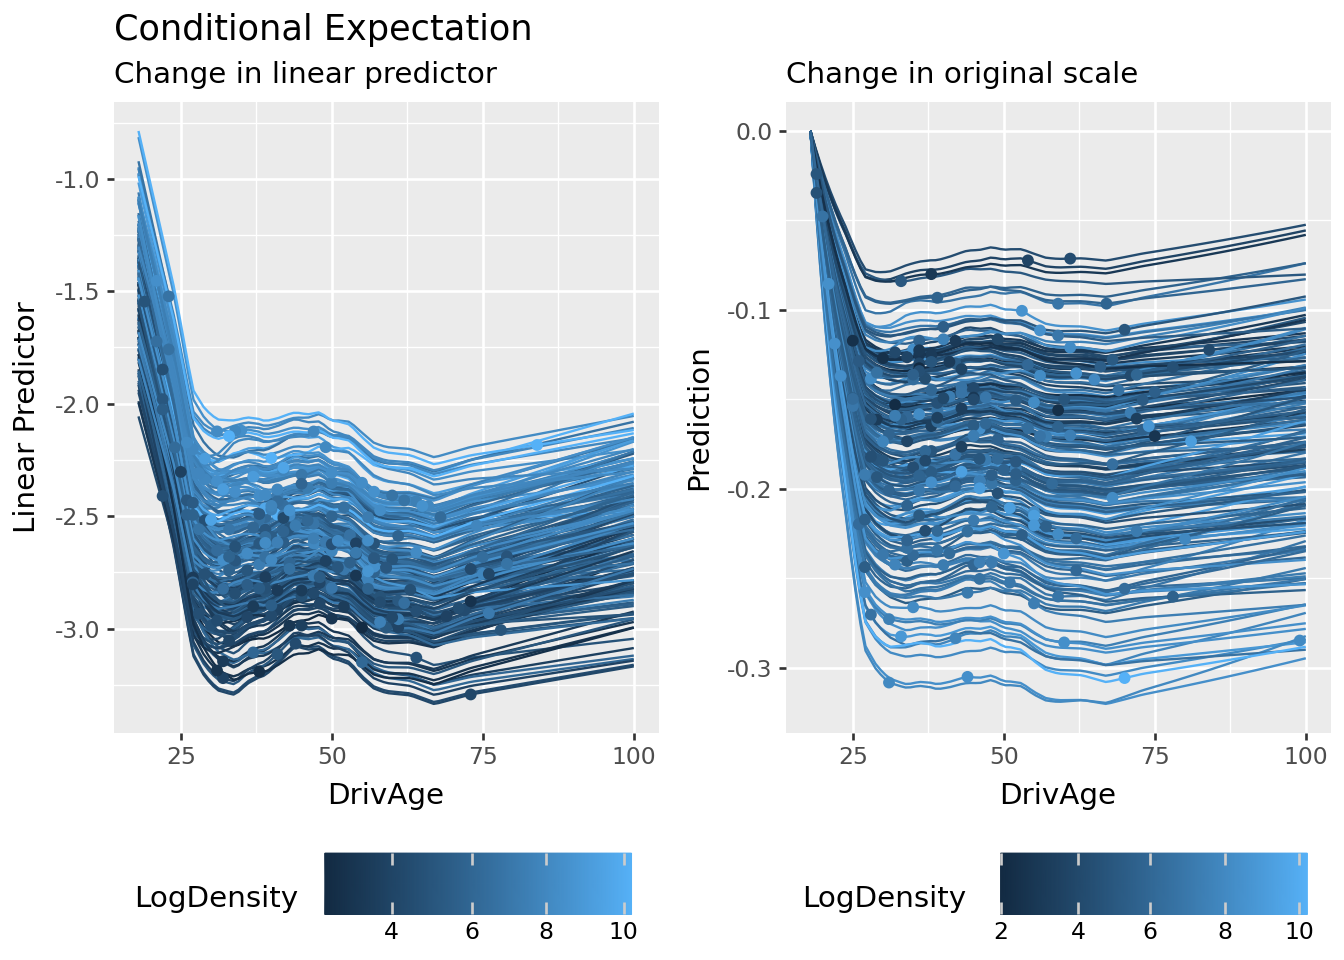

In [22]:
#| label: ice_lgb
ice_lgb_link = mid_lgb.conditional(
  type="link", variable="DrivAge", data=X_train.sample(200)
)
ice_lgb = mid_lgb.conditional(
  variable="DrivAge", data=X_train.sample(200)
)

p1 = (
  ice_lgb_link.plot(theme="bluescale", var_color="LogDensity") +
  theme(legend_position="bottom") +
  labs(y="Linear Predictor",
       title="Conditional Expectation",
       subtitle="Change in linear predictor")
  )
p2 = (
  ice_lgb.plot(style="centered", theme="bluescale",
               var_color="LogDensity") +
  theme(legend_position = "bottom") +
  labs(y = "Prediction", title = "",
     subtitle = "Change in original scale")
  )
display(p1 | p2)

### Additive Attribution

Finally, we perform an Additive Breakdown for individual predictions.
This provides an exact allocation of the LightGBM's prediction into the terms of our surrogate model.

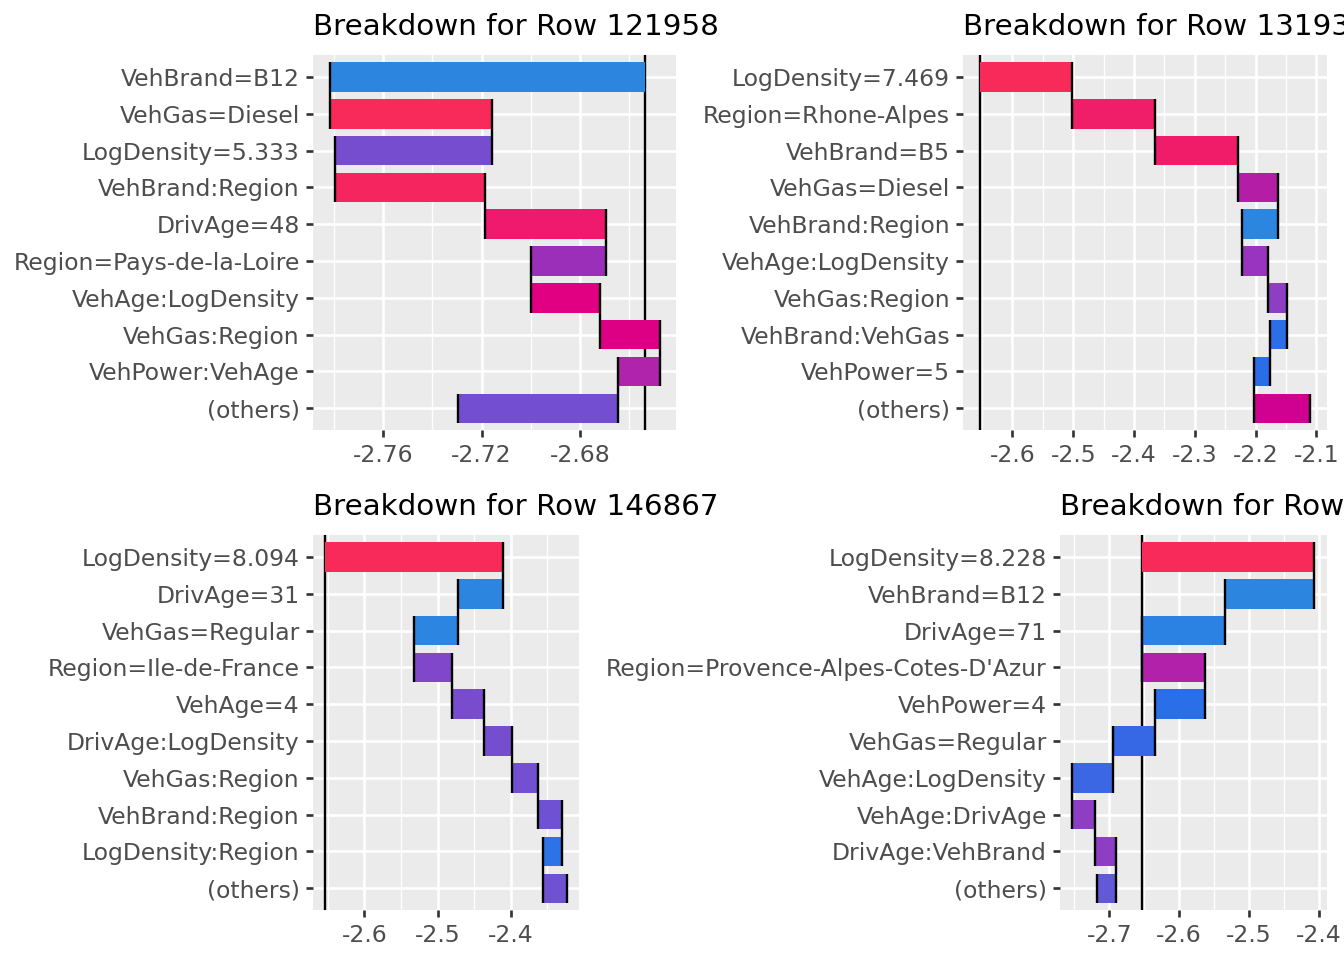

In [23]:
#| label: bd_lgb
np.random.seed(42)
row_ids = sorted(
  np.random.randint(0, train.shape[0], 4).tolist()
)
bd_plots = []
for idx in row_ids:
  bd = mid_lgb.breakdown(row=idx)
  label = "Breakdown for Row " + str(idx)
  p = (
    bd.plot(theme="shap", format_args={'digits': 4},
            max_nterms=10) +
    labs(x="", subtitle=label) +
    theme(legend_position="none")
  )
  bd_plots.append(p)

display(
  (bd_plots[0] | bd_plots[1]) /
  (bd_plots[2] | bd_plots[3]) 
)

## Conclusion

In this notebook, we have demonstrated how **Maximum Interpretation Decomposition (MID)** bridges the gap between predictive performance and model transparency.
By using the `{midlearn}` library, we successfully transformed a complex LightGBM model into a structured, additive representation.

While the surrogate model fidelity may not always be perfect, the crucial advantage lies in our ability to quantify its limitations. 
Through the **uninterpreted variation ratio**, we can directly assess the complexity of the black-box model.
If the fidelity is lower than expected, it serves as a diagnostic signal that the original model relies on high-order interactions or structural complexities that extend beyond second-order effects.

Knowing the extent of this "unexplained" variance is far more valuable than operating in the dark.
It allows actuaries to make informed decisions about whether the additional complexity of a black-box model is justified by its performance, or if a more transparent structure is preferable for regulatory and risk management purposes.

As machine learning models become increasingly prevalent in insurance pricing and reserving, tools like MID will be essential for ensuring that our "black-boxes" remain accountable, reliable, and fundamentally understood.